## Thinking Glasses On

In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

In [3]:
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

In [4]:
methods = ['VG', 'COW', 'LNAM']
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            df = frontier_sample_data[eddy]['T'+str(t)][method]
            # Drop Li 2022 measurement of tilt
            if 'TD' in list(df.columns):
                df = df.drop(columns=['TD'])
            # Centralise at surface center
            central_idx = 14
            if df.shape[0] < central_idx:
                central_idx = df.shape[0] - 1 
            df['x'] = df['x'] - df.iloc[central_idx]['x']
            df['y'] = df['y'] - df.iloc[central_idx]['y']
            # Interpolate to equidistant z-layers
            new_depth = np.arange(0, -z_r[150, 150, d_df.loc[eddy]['T'+str(t)]-1], 10)
            interp_x = interp1d(-df['Depth'], df['x'], kind='linear', fill_value="extrapolate")
            interp_y = interp1d(-df['Depth'], df['y'], kind='linear', fill_value="extrapolate")
            df = pd.DataFrame({
                "x": interp_x(new_depth),
                "y": interp_y(new_depth),
                "Depth": -new_depth
            })
            df['TD'] = np.hypot(df['x'], df['y'])
            frontier_sample_data[eddy]['T'+str(t)][method] = df

In [5]:
methods = ['VG', 'COW', 'LNAM']
min_len = 10000
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            df = frontier_sample_data[eddy]['T'+str(t)][method]
            min_len = min(min_len, df.shape[0])
min_len

27

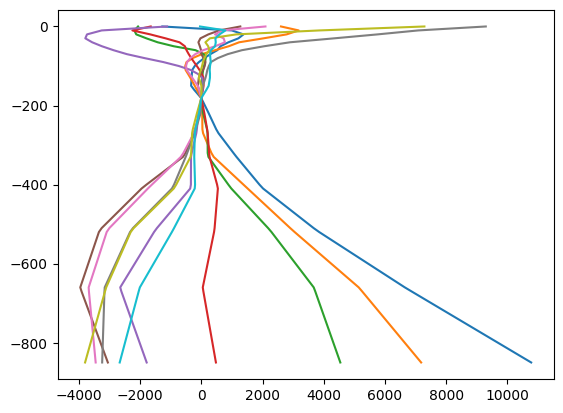

In [12]:
eddy = the_frontier_eddies[0]
method = 'VG'
for t in range(10):
    df = frontier_sample_data[eddy]['T'+str(t)][method]
    plt.plot(df['y'], df['Depth'])

In [7]:
z_r[150,150,9]

np.float64(-73.12784157940781)

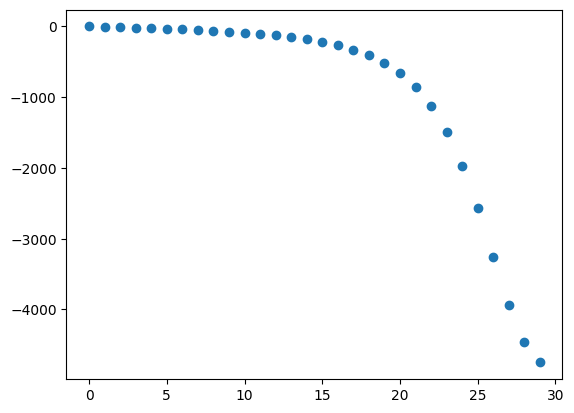

In [8]:
plt.scatter(np.arange(30), z_r[150,150,:])